In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Define the dataset
points = {
    'A': (1, 2),
    'B': (2, 2), 
    'C': (2, 3),
    'D': (8, 8),
    'E': (8, 9),
    'F': (25, 25)
}

# Parameters
epsilon = 2
min_pts = 2

In [2]:
# Convert to array for easier processing
point_names = list(points.keys())
coordinates = np.array(list(points.values()))

print("DBSCAN Algorithm Step-by-Step")
print("=" * 40)
print(f"Parameters: ε = {epsilon}, MinPts = {min_pts}")
print(f"Points: {points}")
print()

DBSCAN Algorithm Step-by-Step
Parameters: ε = 2, MinPts = 2
Points: {'A': (1, 2), 'B': (2, 2), 'C': (2, 3), 'D': (8, 8), 'E': (8, 9), 'F': (25, 25)}



In [3]:
# Step 1: Calculate distance matrix
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

print("Step 1: Distance Matrix")
print("-" * 20)
distance_matrix = np.zeros((len(coordinates), len(coordinates)))

for i in range(len(coordinates)):
    for j in range(len(coordinates)):
        if i != j:
            distance_matrix[i][j] = euclidean_distance(coordinates[i], coordinates[j])

# Display distance matrix
df_distances = pd.DataFrame(distance_matrix, 
                           index=point_names, 
                           columns=point_names)
print(df_distances.round(2))
print()

Step 1: Distance Matrix
--------------------
       A      B      C      D      E      F
A   0.00   1.00   1.41   9.22   9.90  33.24
B   1.00   0.00   1.00   8.49   9.22  32.53
C   1.41   1.00   0.00   7.81   8.49  31.83
D   9.22   8.49   7.81   0.00   1.00  24.04
E   9.90   9.22   8.49   1.00   0.00  23.35
F  33.24  32.53  31.83  24.04  23.35   0.00



In [4]:
# Step 2: Find neighbors within epsilon for each point
print("Step 2: Find ε-neighbors for each point")
print("-" * 40)
neighbors = {}
for i, name in enumerate(point_names):
    neighbors[name] = []
    for j, other_name in enumerate(point_names):
        if i != j and distance_matrix[i][j] <= epsilon:
            neighbors[name].append(other_name)
    print(f"Point {name}: neighbors = {neighbors[name]} (count: {len(neighbors[name])})")
print()

Step 2: Find ε-neighbors for each point
----------------------------------------
Point A: neighbors = ['B', 'C'] (count: 2)
Point B: neighbors = ['A', 'C'] (count: 2)
Point C: neighbors = ['A', 'B'] (count: 2)
Point D: neighbors = ['E'] (count: 1)
Point E: neighbors = ['D'] (count: 1)
Point F: neighbors = [] (count: 0)



In [5]:
# Step 3: Classify points as core, border, or noise
print("Step 3: Classify points")
print("-" * 25)
core_points = []
border_points = []
noise_points = []

for name in point_names:
    neighbor_count = len(neighbors[name])
    if neighbor_count >= min_pts:
        core_points.append(name)
        print(f"Point {name}: CORE (has {neighbor_count} neighbors ≥ {min_pts})")
    else:
        # Check if it's a neighbor of any core point
        is_border = False
        for core in core_points:
            if name in neighbors.get(core, []):
                is_border = True
                break
        
        if is_border:
            border_points.append(name)
            print(f"Point {name}: BORDER (neighbor of core point)")
        else:
            # We'll determine this after finding all core points
            print(f"Point {name}: POTENTIAL NOISE (has {neighbor_count} neighbors < {min_pts})")

print()

Step 3: Classify points
-------------------------
Point A: CORE (has 2 neighbors ≥ 2)
Point B: CORE (has 2 neighbors ≥ 2)
Point C: CORE (has 2 neighbors ≥ 2)
Point D: POTENTIAL NOISE (has 1 neighbors < 2)
Point E: POTENTIAL NOISE (has 1 neighbors < 2)
Point F: POTENTIAL NOISE (has 0 neighbors < 2)



In [6]:
# Step 4: Manual DBSCAN clustering
print("Step 4: Form clusters")
print("-" * 20)

# Initialize clusters
clusters = {}
cluster_id = 0
visited = set()
point_to_cluster = {}

def dfs_cluster(point, cluster_id, visited, point_to_cluster):
    """Depth-First Search to form clusters"""
    if point in visited:
        return
    
    visited.add(point)
    point_to_cluster[point] = cluster_id
    
    # If it's a core point, visit all its unvisited neighbors
    if point in core_points:
        for neighbor in neighbors[point]:
            if neighbor not in visited:
                dfs_cluster(neighbor, cluster_id, visited, point_to_cluster)

# Process each core point
for core_point in core_points:
    if core_point not in visited:
        print(f"Starting cluster {cluster_id} from core point {core_point}")
        dfs_cluster(core_point, cluster_id, visited, point_to_cluster)
        cluster_id += 1

# Classify remaining points as noise
final_noise_points = []
for point in point_names:
    if point not in point_to_cluster:
        final_noise_points.append(point)
        point_to_cluster[point] = -1  # -1 indicates noise

print()
print("Final Classification:")
print("-" * 20)
for cluster_num in range(cluster_id):
    cluster_points = [p for p, c in point_to_cluster.items() if c == cluster_num]
    print(f"Cluster {cluster_num}: {cluster_points}")

if final_noise_points:
    print(f"Noise points: {final_noise_points}")
else:
    print("Noise points: None")

Step 4: Form clusters
--------------------
Starting cluster 0 from core point A

Final Classification:
--------------------
Cluster 0: ['A', 'B', 'C']
Noise points: ['D', 'E', 'F']


In [7]:
# Step 5: Verify with sklearn DBSCAN
print()
print("Step 5: Verification with sklearn DBSCAN")
print("-" * 40)
dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
sklearn_labels = dbscan.fit_predict(coordinates)

print("sklearn results:")
for i, (name, label) in enumerate(zip(point_names, sklearn_labels)):
    if label == -1:
        print(f"Point {name}: Noise")
    else:
        print(f"Point {name}: Cluster {label}")


Step 5: Verification with sklearn DBSCAN
----------------------------------------
sklearn results:
Point A: Cluster 0
Point B: Cluster 0
Point C: Cluster 0
Point D: Cluster 1
Point E: Cluster 1
Point F: Noise


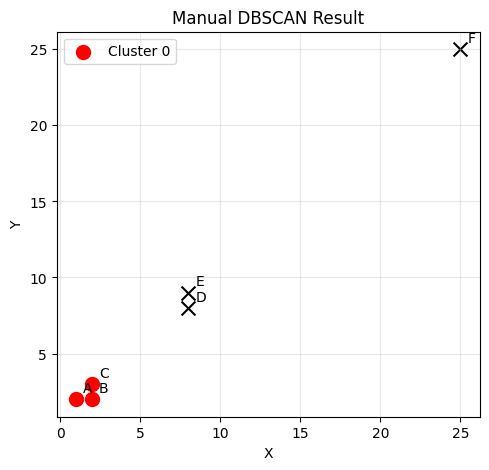

In [8]:
# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Manual DBSCAN result
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, (name, coord) in enumerate(zip(point_names, coordinates)):
    cluster = point_to_cluster[name]
    if cluster == -1:
        plt.scatter(coord[0], coord[1], c='black', marker='x', s=100, label='Noise' if i == 0 else "")
    else:
        plt.scatter(coord[0], coord[1], c=colors[cluster % len(colors)], s=100, 
                   label=f'Cluster {cluster}' if cluster not in [point_to_cluster[point_names[j]] for j in range(i)] else "")
    plt.annotate(name, (coord[0], coord[1]), xytext=(5, 5), textcoords='offset points')

plt.title('Manual DBSCAN Result')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)

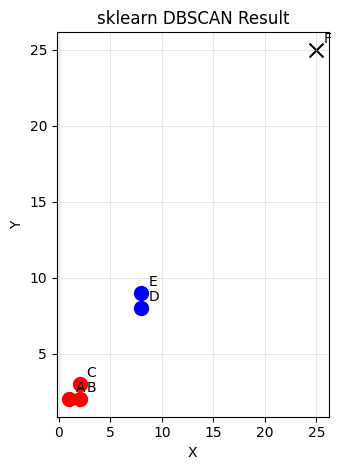


Summary:
----------
Core points: ['A', 'B', 'C']
Total clusters found: 1
Noise points: ['D', 'E', 'F']


In [9]:
# Plot 2: sklearn DBSCAN result
plt.subplot(1, 2, 2)
for i, (name, coord, label) in enumerate(zip(point_names, coordinates, sklearn_labels)):
    if label == -1:
        plt.scatter(coord[0], coord[1], c='black', marker='x', s=100)
    else:
        plt.scatter(coord[0], coord[1], c=colors[label % len(colors)], s=100)
    plt.annotate(name, (coord[0], coord[1]), xytext=(5, 5), textcoords='offset points')

plt.title('sklearn DBSCAN Result')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print()
print("Summary:")
print("-" * 10)
print(f"Core points: {core_points}")
print(f"Total clusters found: {cluster_id}")
print(f"Noise points: {final_noise_points}")